In [1]:
import xarray as xr
import pop_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import os                   # to interact with the operating system
import pandas as pd
import gsw                  # compute potential density

In [2]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
#setting up of regional mask
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

def find_corresponding_number(vvel_filename):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_number_to_find = None
    for filename in vvel_list:
        if filename.split()[1] == vvel_filename:
            vvel_number_to_find = vvel_dict[filename.split()[1]]
            break
    return vvel_number_to_find

#def get_value_for_index(csv_file, target_index):
#    # Read the CSV file into a DataFrame
#    df = pd.read_csv(csv_file)
#    value = df.loc[df['Index'] == target_index, 'Values'].values
#    return value

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
member = 'vvel_1281.015.nc'
csv_file = 'events_dens_spg.csv'
member_number = find_corresponding_number(member)
#event = get_value_for_index(csv_file, member_number)

In [4]:
# Set parameters
event = 107*12
before = 40*12
after = 20*12
tp = 3*12  

In [5]:
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'+member[5:]
ds_sst = xr.open_dataset(temp_file).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)

In [6]:
salt_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'+member[5:]
ds_sss = xr.open_dataset(salt_file).isel(z_t=0).where(mask3d == 1).roll(nlon=-100)

In [7]:
hmxl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/hmxl/hmxl_'+member[5:]
ds_hmxl = xr.open_dataset(hmxl_file).where(mask3d == 1).roll(nlon=-100)

In [8]:
ds_sigma = xr.open_dataset(temp_file).where(mask3d == 1).roll(nlon=-100)
ds_sigma_salt = xr.open_dataset(salt_file).where(mask3d == 1).roll(nlon=-100)

In [9]:
ds_sigma = ds_sigma.update(ds_sigma_salt[["SALT"]])

### Compute potential density ref 2000dbar
# Conservative Temperature
CT = gsw.conversions.CT_from_pt(ds_sigma.SALT, ds_sigma.TEMP)
# potential density
ds_sigma['SIGMA_2'] = gsw.density.sigma2(ds_sigma.SALT, CT)
ds_sigma['SIGMA_2'].attrs['units'] = 'kg/m^3 - 1000'
ds_sigma['SIGMA_2'].attrs['long_name'] = 'Potential Density at 2000 dbar'

In [10]:
ssh_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/ssh/ssh_'+member[5:]
ds_ssh = xr.open_dataset(ssh_file).where(mask3d == 1).roll(nlon=-100)

# SST Anomalies

In [11]:
# Calculate averages for temperature
period1_avg_temp = ds_sst.TEMP.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_temp = ds_sst.TEMP.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_temp = period2_avg_temp - period1_avg_temp

In [12]:
vmin_temp, vmax_temp = -4.0, 4.0 

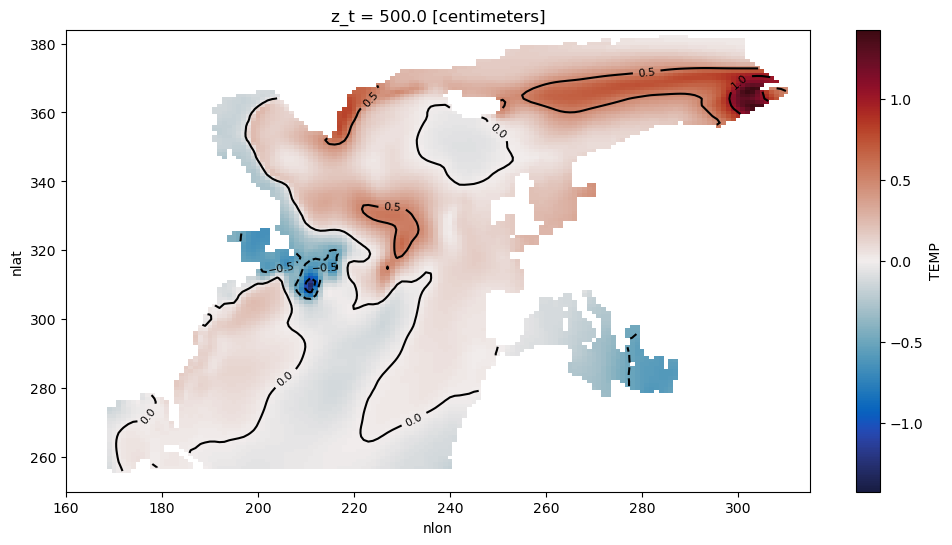

In [13]:
plt.figure(figsize=(12, 6))
#difference_temp_plot = difference_temp.plot(cmap=cmo.diff, vmin=vmin_temp, vmax=vmax_temp)
difference_temp_plot = difference_temp.plot(cmap=cmo.balance)#, vmin=vmin_temp, vmax=vmax_temp)
plt.title('Surface Temperature Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_temp = difference_temp.plot.contour(colors='k') 
plt.clabel(contour_temp, inline=True, fontsize=8)
plt.show()

# SSS Anomalies

In [14]:
# Calculate averages for salinity
period1_avg_salt = ds_sss.SALT.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_salt = ds_sss.SALT.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_salt = period2_avg_salt - period1_avg_salt

In [15]:
vmin_salt, vmax_salt = -1.0, 1.0  

<a list of 12 text.Text objects>

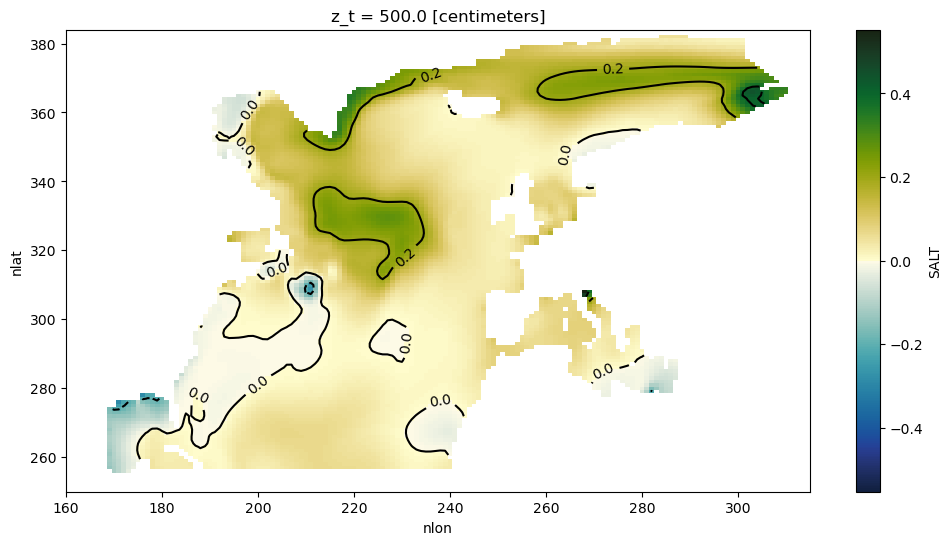

In [16]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_salt_plot = difference_salt.plot(cmap=cmo.delta)#, vmin=vmin_salt, vmax=vmax_salt)
plt.title('Surface Salinity Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_salt.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=True, fontsize=10)

# HMXL Anomalies

In [17]:
# Calculate averages for mixed layer depth
period1_avg_hmxl = ds_hmxl.HMXL.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_hmxl = ds_hmxl.HMXL.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_hmxl = period2_avg_hmxl - period1_avg_hmxl

In [18]:
#vmin_hmxl, vmax_hmxl = -1.0, 1.0  

<a list of 45 text.Text objects>

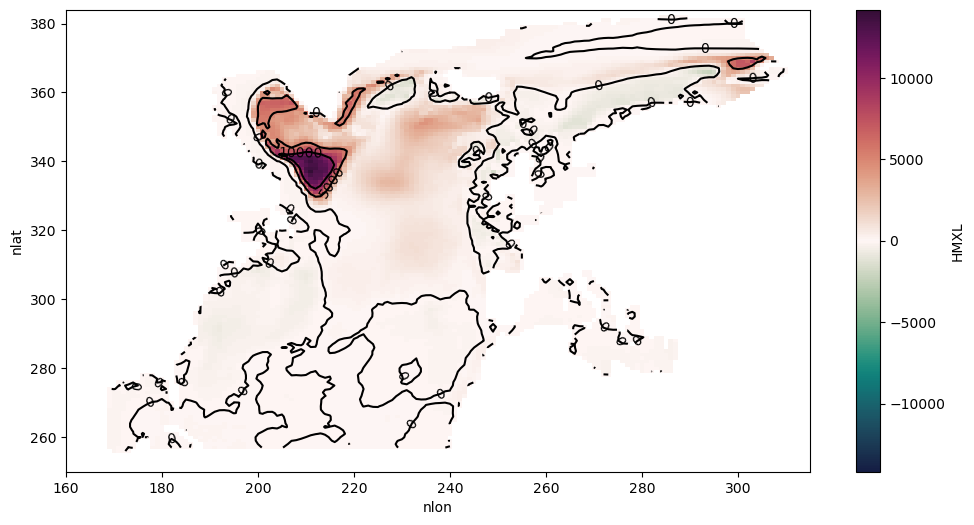

In [19]:
plt.figure(figsize=(12, 6))
#difference_hmxl_plot = difference_hmxl.plot(cmap=cmo.diff)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
difference_hmxl_plot = difference_hmxl.plot(cmap=cmo.curl)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
plt.title('Mixed Layer Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_hmxl = difference_hmxl.plot.contour(colors='k') 
plt.clabel(contour_hmxl, inline=False, fontsize=10)

# SSH Anomalies

In [20]:
# Calculate averages for mixed layer depth
period1_avg_ssh = ds_ssh.SSH.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_ssh = ds_ssh.SSH.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_ssh = period2_avg_ssh - period1_avg_ssh

<a list of 21 text.Text objects>

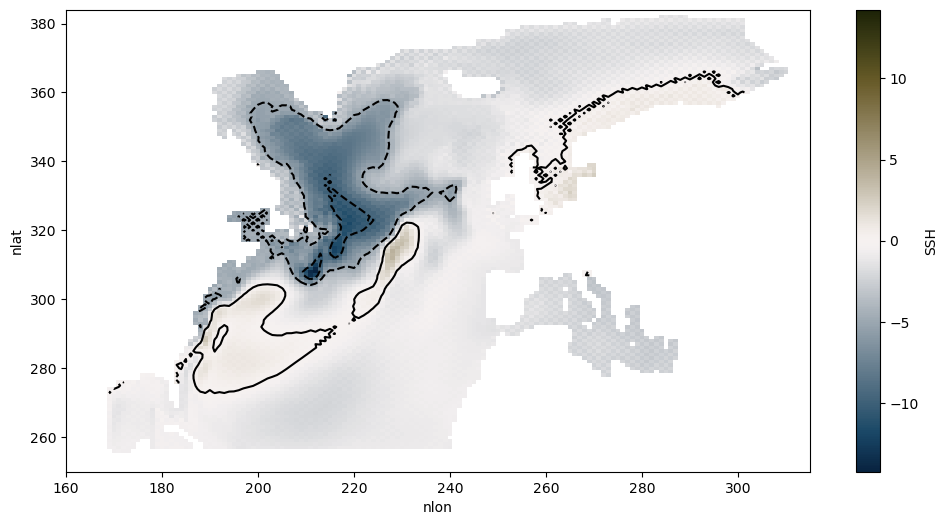

In [21]:
plt.figure(figsize=(12, 6))
#differences_plot = difference_ssh.plot(cmap=cmo.diff)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
difference_ssh_plot = difference_ssh.plot(cmap=cmo.diff)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
plt.title('Mixed Layer Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_ssh = difference_ssh.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

# Density computations

In [22]:
period1_avg_sigma = ds_sigma.SIGMA_2.isel(time=slice(event-before, event-tp)).mean(dim='time')
period2_avg_sigma = ds_sigma.SIGMA_2.isel(time=slice(event+tp, event+after)).mean(dim='time')
difference_sigma = period2_avg_sigma - period1_avg_sigma

In [26]:
vmin_sigma, vmax_sigma = -0.5, 0.5  

# Latitudinal Density Anomaly

ValueError: DataArray must be 2d

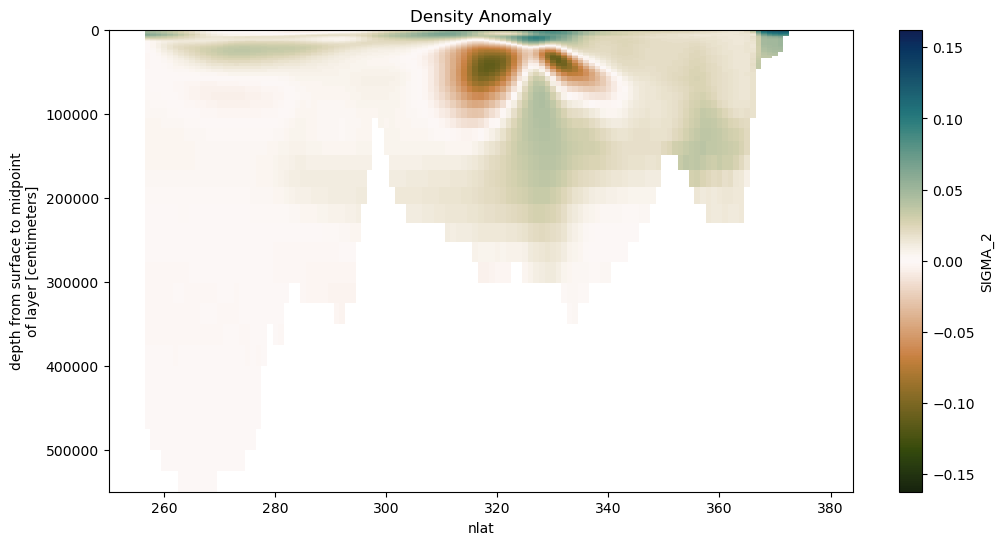

In [23]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_sigma_plot = difference_sigma.isel(nlon=230).plot(cmap=cmo.tarn,yincrease=False)#, vmin=vmin_salt, vmax=vmax_salt)
plt.title('Density Anomaly')
#plt.xlim([160, 315])
plt.xlim([250, 384])
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

# 500-1000 meters Density Anomaly

ValueError: DataArray must be 2d

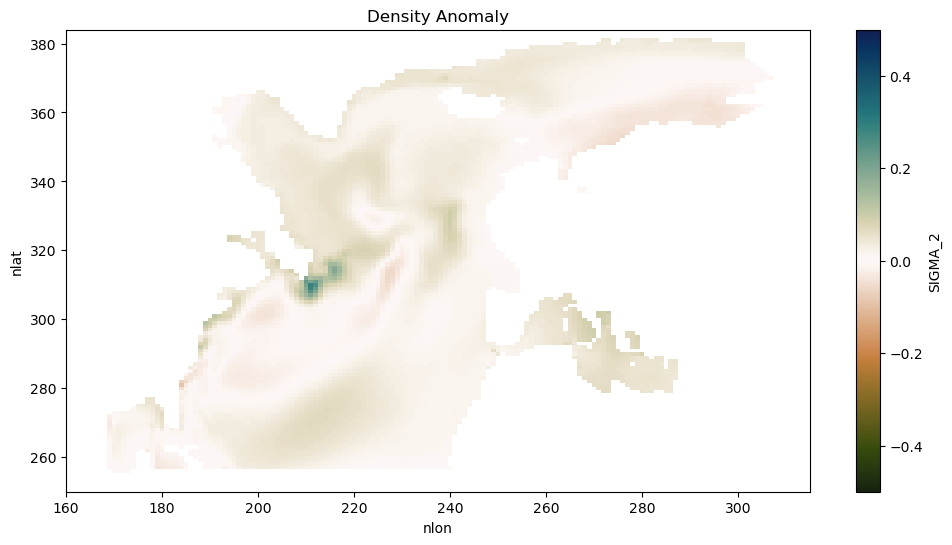

In [27]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_sigma_plot = difference_sigma.isel(z_t=slice(14,20)).mean(dim='z_t').plot(cmap=cmo.tarn, vmin=vmin_sigma, vmax=vmax_sigma)
plt.title('Density Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)

ValueError: DataArray must be 2d

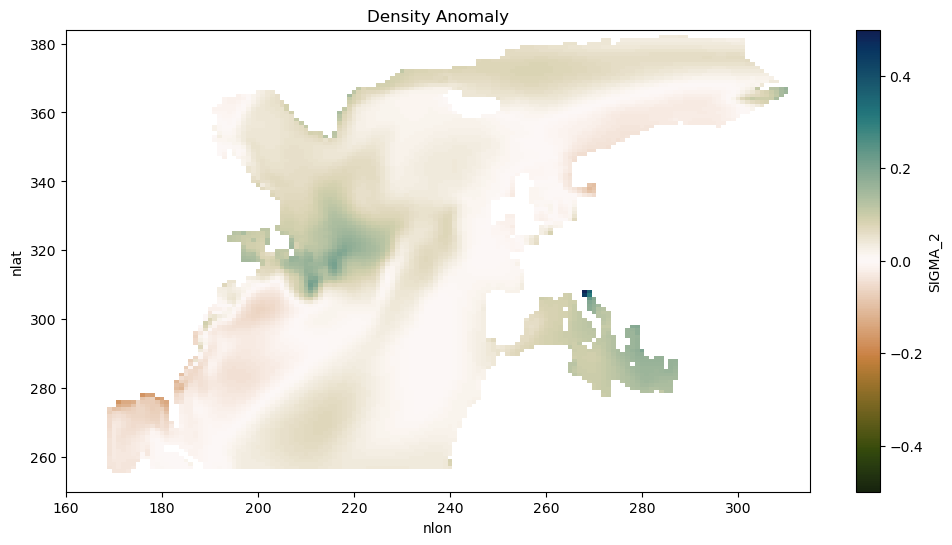

In [28]:
plt.figure(figsize=(12, 6))
#difference_salt_plot = difference_salt.plot(cmap=cmo.diff, vmin=vmin_salt, vmax=vmax_salt)
difference_sigma_plot = difference_sigma.isel(z_t=slice(0,14)).mean(dim='z_t').plot(cmap=cmo.tarn, vmin=vmin_sigma, vmax=vmax_sigma)
plt.title('Density Anomaly')
plt.xlim([160, 315])
plt.ylim([250, 384])
contour_salt = difference_sigma.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=False, fontsize=10)